In [104]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.dates as mdates  
from sklearn import linear_model

from tensorflow.keras.models import Sequential 
from keras.layers import Dense  
import keras.backend as K 
from keras.callbacks import EarlyStopping  
from keras.optimizers import Adam 
from keras.models import load_model 
from keras.layers import LSTM  
from tensorflow.keras.utils import plot_model

# Package for additional features
from talib import abstract as ta
from talib import RSI
from talib import MACD

# Fine tuning
from sklearn.model_selection import GridSearchCV





In [105]:
# Define the ticker symbol for the company (e.g., Apple Inc. with the symbol AAPL)
ticker_symbol = "AAPL"

start_date = "2010-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

data = yf.download(ticker_symbol, start=start_date, end=end_date)

df = pd.DataFrame(data)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.478999,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490199,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386963,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375157,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417542,447610800


<Axes: xlabel='Date'>

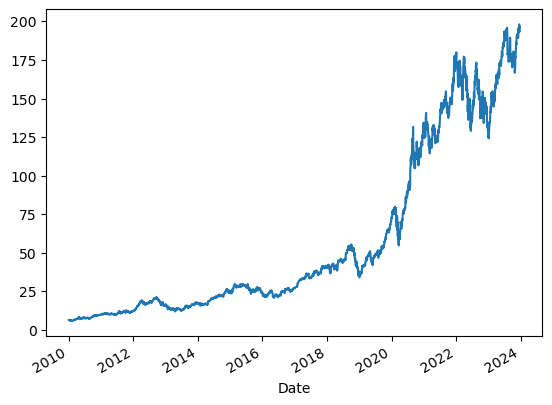

In [106]:
df['Adj Close'].plot()

In [107]:
# Select the features and the target 
target_y = df['Adj Close']
X_feat = df.iloc[:,0:3]

In [108]:
# Scale the data using standard scaler 
# Standard scaler will scale between -1 and 1 

sc = StandardScaler() 
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns = X_feat.columns, 
                    data = X_ft, 
                    index = X_feat.index)

X_ft.shape

(3518, 3)

In [109]:
# Group features and target into 1 df 
stock_df = pd.concat([X_ft, df['Close']], axis = 1)
stock_df.head()


,Open,High,Low,Close
Date,,,,
2010-01-04,-0.943540,-0.943773,-0.942901,7.643214
2010-01-05,-0.942784,-0.943076,-0.942332,7.656429
2010-01-06,-0.942926,-0.943306,-0.943966,7.534643
2010-01-07,-0.944627,-0.945371,-0.945077,7.520714
2010-01-08,-0.945565,-0.945371,-0.945070,7.570714


In [110]:
# Define a function to do split into training and testing 

def lstm_split(data, n_steps):
    X, y = [], []

    for i in range(len(data) - n_steps+1): 
        X.append(data[i:i + n_steps, :-1])
        y.append(data[i + n_steps -1, -1] )

    return np.array(X), np.array(y) 

In [111]:
# Generate train and test set
X1, y1 = lstm_split(stock_df.values, n_steps = 2) # Predict based on the data of past 2 days 

train_split = 0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = stock_df.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(3517, 2, 3) (2814, 2, 3) (703, 2, 3) (703,)


## Build a simple LSTM model 

In [112]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 32)                4608      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
# Fit model to training data 

history = lstm.fit(X_train, y_train,
                   epochs=100, batch_size=4,
                   verbose=2, shuffle=False)

Epoch 1/100
704/704 - 1s - loss: 585.6378 - 897ms/epoch - 1ms/step
Epoch 2/100
704/704 - 0s - loss: 707.1323 - 437ms/epoch - 621us/step
Epoch 3/100
704/704 - 0s - loss: 132.8498 - 435ms/epoch - 617us/step
Epoch 4/100
704/704 - 0s - loss: 66.0165 - 434ms/epoch - 616us/step
Epoch 5/100
704/704 - 0s - loss: 29.3586 - 432ms/epoch - 614us/step
Epoch 6/100
704/704 - 1s - loss: 13.6739 - 527ms/epoch - 749us/step
Epoch 7/100
704/704 - 0s - loss: 7.1157 - 480ms/epoch - 681us/step
Epoch 8/100
704/704 - 0s - loss: 4.3222 - 431ms/epoch - 613us/step
Epoch 9/100
704/704 - 0s - loss: 2.9609 - 449ms/epoch - 638us/step
Epoch 10/100
704/704 - 0s - loss: 2.2131 - 428ms/epoch - 608us/step
Epoch 11/100
704/704 - 0s - loss: 1.8118 - 465ms/epoch - 660us/step
Epoch 12/100
704/704 - 0s - loss: 1.6774 - 434ms/epoch - 617us/step
Epoch 13/100
704/704 - 0s - loss: 1.6507 - 433ms/epoch - 615us/step
Epoch 14/100
704/704 - 0s - loss: 1.5883 - 434ms/epoch - 617us/step
Epoch 15/100
704/704 - 0s - loss: 1.5151 - 433ms/e

## Performance evaluation 

In [114]:
# Evaluate the performance on a test set 

y_pred = lstm.predict(X_test)
y_pred.shape

22/22 [==============================] - 0s 424us/step


(703, 1)

In [115]:
print(y_pred.shape)
print(y_test.shape)

(703, 1)
(703,)


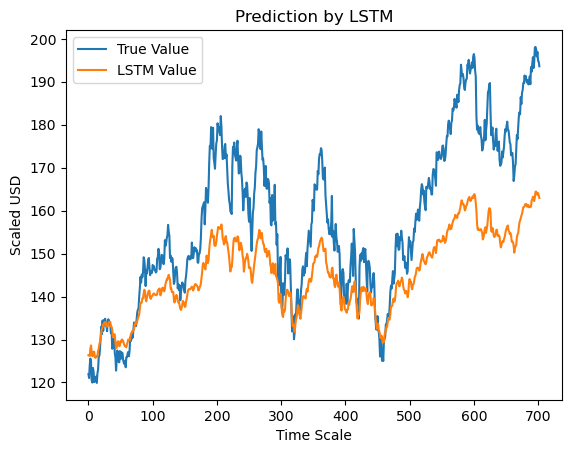

In [116]:
#Predicted vs True Adj Close Value – LSTM

plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()